In [1]:
from transformers import AutoProcessor, AutoModelForImageTextToText,AutoModelForCausalLM,AutoTokenizer
from transformers.image_utils import load_image
from transformers import AutoTokenizer
from PIL import Image
import torch

In [11]:
import json

In [71]:
# Load model and processor
model_id_vlm = "LiquidAI/LFM2-VL-450M"
model_vlm = AutoModelForImageTextToText.from_pretrained(
    model_id_vlm,
    device_map={"": "cpu"},  # force CPU
    torch_dtype="float32",   # safer on CPU
    trust_remote_code=True
)
processor_vlm = AutoProcessor.from_pretrained(model_id_vlm, trust_remote_code=True)

# ===== LOAD TEST IMAGE =====
# image_path = "./detected/003843_detections.jpg"
image_path = "data/test_mm_7.36.jpg"
image = Image.open(image_path)
if image.mode != "RGB":
    image = image.convert("RGB")



# Load model and processor
model_id_llm = "LiquidAI/LFM2-350M"
model_llm = AutoModelForCausalLM.from_pretrained(
    model_id_llm,
    device_map="auto",
    torch_dtype="bfloat16",
    trust_remote_code=True
)
tokenizer_vlm = AutoTokenizer.from_pretrained(model_id_llm)

conversation = [
    {
        "role": "user",
        "content": [
            {"type": "image", "image": image},
            {
                "type": "text",
                "text": """You are an expert gauge inspector. Carefully analyze the image of the gauge and do the following:
1. Identify the type of gauge (e.g., thermometer, pressure gauge, etc.).
2. Provide the current meter reading shown by the needle.
3. State the unit of measurement.
4. Present the final reading clearly in the format: "<value> <unit>".
Only provide the direct reading, no extra explanation."""
            },
        ],
    },
]


# Generate Answer
inputs = processor_vlm.apply_chat_template(
    conversation,
    add_generation_prompt=True,
    return_tensors="pt",
    return_dict=True,
    tokenize=True,
).to(model_vlm.device)


outputs = model_vlm.generate(**inputs, max_new_tokens=512)
decoded = processor_vlm.batch_decode(outputs, skip_special_tokens=True)[0]

# Extract only the assistant's reply
if "assistant" in decoded:
    response = decoded.split("assistant", 1)[1].strip()
else:
    response = decoded.strip()

print("\n--- Model Response ---")
print(response)

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]


--- Model Response ---
<7.36 mm> <mm>


In [72]:
# response = "<98.36 mm> <mm>"

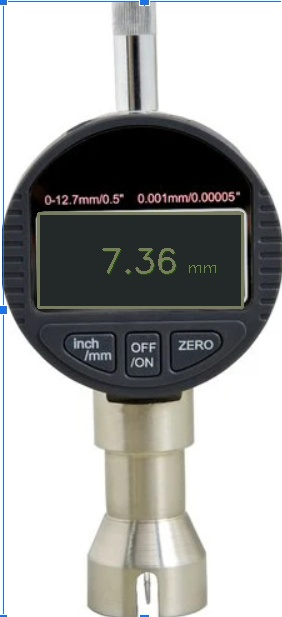

In [73]:
image

In [74]:
def turn_on_light(room: str):
    return {"status": f"Light in {room} turned ON"}

def turn_off_light(room: str):
    return {"status": f"Light in {room} turned OFF"}

In [75]:
# Map function names to actual implementations
TOOLS = {
    "turn_on_light": turn_on_light,
    "turn_off_light": turn_off_light
}

In [76]:
# --------------------------
# Define tools JSON for LFM2
# --------------------------
tools_json = [
    {
        "name": "turn_on_light",
        "description": "Turn on the light in a specified room",
        "parameters": {
            "type": "object",
            "properties": {
                "room": {"type": "string", "description": "Name of the room"}
            },
            "required": ["room"]
        }
    },
    {
        "name": "turn_off_light",
        "description": "Turn off the light in a specified room",
        "parameters": {
            "type": "object",
            "properties": {
                "room": {"type": "string", "description": "Name of the room"}
            },
            "required": ["room"]
        }
    }
]

In [77]:
meter_reading = response

In [78]:
meter_reading

'<7.36 mm> <mm>'

In [54]:
# prompt = f"""
# <|startoftext|><|im_start|>system
# List of tools: <|tool_list_start|>{json.dumps(tools_json)}<|tool_list_end|><|im_end|>
# <|im_start|>user
# The meter reading is {meter_reading} mm.
# If the reading is greater than 80 mm, call turn_off_light with room="living_room".
# If it is 80 or less, do nothing.
# <|im_end|>
# <|im_start|>assistant
# """

In [57]:
# prompt = f"""
# <|startoftext|><|im_start|>system
# You are a controller that must decide whether to call a tool.
# Always respond ONLY with a valid tool call in JSON format.
# Do not explain or add text.

# List of tools: <|tool_list_start|>{json.dumps(tools_json)}<|tool_list_end|><|im_end|>

# <|im_start|>user
# The meter reading is {meter_reading} mm.
# If the reading is greater than 80 mm, call turn_off_light with room="living_room".
# If it is 80 or less, output {{}} to indicate no action.
# <|im_end|>
# <|im_start|>assistant
# """


In [61]:
# prompt = f"""
# <|startoftext|><|im_start|>system
# You are a controller that must decide whether to call a tool.
# Always respond ONLY with a JSON object matching this schema:

# {{
#   "name": "<tool_name>",
#   "arguments": {{ "room": "<room_name>" }}
# }}

# - If no tool is needed, respond with: {{}}
# - Do not explain or add text.
# <|im_end|>

# <|im_start|>user
# The meter reading is {meter_reading} mm.
# If the reading is greater than 80 mm, call turn_off_light with room="living_room".
# If it is 80 or less, output {{}}.
# <|im_end|>
# <|im_start|>assistant
# """


In [79]:
prompt = f"""
<|startoftext|><|im_start|>system
You are a controller that must decide whether to call a tool.
Always respond ONLY with a JSON object in this exact format:

{{"name": "turn_off_light", "arguments": {{"room": "living_room"}}}}

OR, if no action is needed:

{{}}

Nothing else is allowed. No quotes around keys unless shown. No extra fields. No explanation.
<|im_end|>

<|im_start|>user
The meter reading is {meter_reading} mm.
If the reading is greater than 80 mm, respond with the turn_off_light call.
If it is 80 or less, respond with {{}}.
<|im_end|>
<|im_start|>assistant
"""


In [80]:
# Load model and tokenizer
model_id = "LiquidAI/LFM2-350M"
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map={"": "cpu"},  # force CPU
    torch_dtype="float32",   # safer on CPU
)
tokenizer_llm = AutoTokenizer.from_pretrained(model_id)

# Generate answer
# prompt = "What is the reading ? " + prompt 
input_ids = tokenizer_llm.apply_chat_template(
    [{"role": "user", "content": prompt}],
    add_generation_prompt=True,
    return_tensors="pt",
    tokenize=True,
).to(model.device)

output = model.generate(
    input_ids,
    do_sample=True,
    temperature=0.3,
    min_p=0.15,
    repetition_penalty=1.05,
    max_new_tokens=512,
)

print(tokenizer_llm.decode(output[0], skip_special_tokens=False))

<|startoftext|><|im_start|>user

<|startoftext|><|im_start|>system
You are a controller that must decide whether to call a tool.
Always respond ONLY with a JSON object in this exact format:

{"name": "turn_off_light", "arguments": {"room": "living_room"}}

OR, if no action is needed:

{}

Nothing else is allowed. No quotes around keys unless shown. No extra fields. No explanation.
<|im_end|>

<|im_start|>user
The meter reading is <7.36 mm> <mm> mm.
If the reading is greater than 80 mm, respond with the turn_off_light call.
If it is 80 or less, respond with {}.
<|im_end|>
<|im_start|>assistant
<|im_end|>
<|im_start|>assistant
If the reading is greater than 80 mm, respond with turn_off_light(<7.36 mm, 80 mm). Otherwise, return to the previous response.

{}
}<|im_end|>


In [81]:
decoded_llm = tokenizer_llm.decode(output[0], skip_special_tokens=True)
print("\n--- LLM Decision ---")
print(decoded_llm)

# ----------------------------
# Step 5: Execute function if needed
# ----------------------------
if "turn_off_light" in decoded_llm:
    result = turn_off_light("living_room")
    print("\n--- Action Taken ---")
    print(result)
else:
    print("\n--- Action Taken ---\nNo action (reading safe).")


--- LLM Decision ---
user

system
You are a controller that must decide whether to call a tool.
Always respond ONLY with a JSON object in this exact format:

{"name": "turn_off_light", "arguments": {"room": "living_room"}}

OR, if no action is needed:

{}

Nothing else is allowed. No quotes around keys unless shown. No extra fields. No explanation.


user
The meter reading is <7.36 mm> <mm> mm.
If the reading is greater than 80 mm, respond with the turn_off_light call.
If it is 80 or less, respond with {}.

assistant

assistant
If the reading is greater than 80 mm, respond with turn_off_light(<7.36 mm, 80 mm). Otherwise, return to the previous response.

{}
}

--- Action Taken ---
{'status': 'Light in living_room turned OFF'}


In [68]:
# import json

# try:
#     action = json.loads(decoded_llm.strip().split("assistant")[-1].strip())
#     if action and action.get("name") == "turn_off_light":
#         result = turn_off_light(action["arguments"]["room"])
#         print("\n--- Action Taken ---")
#         print(result)
#     else:
#         print("\n--- Action Taken ---\nNo action (reading safe).")
# except json.JSONDecodeError:
#     print("\n--- Error ---\nInvalid LLM output:", decoded_llm)
